In [1]:
#!pip install ipywidgets
#!pip3 install optuna
!jupyter nbextension enable --py widgetsnbextension
# Подружаем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nafig
import miceforest as mf
import optuna
import hyperopt
from optuna.samplers import TPESampler
from catboost.utils import eval_metric
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from matplotlib.colors import ListedColormap
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import TargetEncoder, StandardScaler
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from numpy.random import RandomState

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Читаем данные

acute_treatment_data = pd.read_csv("./acute_t_dataset.csv")
chronic_treatment_data = pd.read_csv("./chronic_t_dataset.csv")
acute_disease_data = pd.read_csv("./acute_d_dataset.csv")
chronic_disease_data = pd.read_csv("./chronic_d_dataset.csv")
treatment_data = pd.read_csv("./t_dataset.csv")
disease_data = pd.read_csv("./d_dataset.csv")

# Работаем с острым датасетом по лечению

### Предобрабатываем и убираем ненужные переменные

In [3]:
nafig.na_text_barplot(acute_disease_data, line_height=1.5)

AttributeError: module 'nafig' has no attribute 'na_text_barplot'

In [4]:
acute_disease_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SITE                240 non-null    int64  
 1   SUBJID              240 non-null    int64  
 2   BIRTHDTC            240 non-null    object 
 3   SEX                 240 non-null    object 
 4   PSOCN               240 non-null    object 
 5   PRSTDTC             239 non-null    object 
 6   PRSCHEM             240 non-null    object 
 7   TIMGDOSE            240 non-null    int64  
 8   HATGDOSE            240 non-null    int64  
 9   PRENDTC             149 non-null    object 
 10  TRNUM               240 non-null    int64  
 11  TRTYPE              240 non-null    object 
 12  TRDTC               240 non-null    object 
 13  TRSOURCE            240 non-null    object 
 14  COND                240 non-null    object 
 15  CONDTYPE            240 non-null    object 
 16  ALIVE   

In [3]:
# До кучи удалим и PRSCHEM и COND. Их слишком много, они роняют запоонятель NA 
acute_disease_data = acute_disease_data.drop(["PTSTAT", "SEVGRADE", "SEVTYPE", "PRSCHEM", "COND"], axis = 1)
acute_disease_data = acute_disease_data.drop(list(acute_disease_data.filter(regex='chronic')), axis = 1)
# Устраним малозначимеы переменные
acute_disease_data = acute_disease_data.drop(["GVHDMETH"], axis = 1)
# Чистим датасет от пациентов, для которых неизвестен исход
acute_disease_data["REFSTYN"].map({"stated subjectively": "yes"})
#acute_disease_data = acute_disease_data.drop(acute_disease_data.query("REFSTYN not in ['yes', 'no']").index, axis=0)
# Уберем переменные с данными о резистентности, на которых легко переобучится
acute_disease_data = acute_disease_data.drop(["REFSTDTC", "REFSTLOT"], axis=1)
# Уберем даты в чистом виде
acute_disease_data = acute_disease_data.loc[:, ~acute_disease_data.columns.str.endswith('DTC')]
# Поменяем в ряде колонок "unknown" и тому подобное на NA
acute_disease_data.replace('unknown', np.nan, inplace=True)

In [4]:
# X = acute_disease_data.drop(["REFSTYN"], axis=1)
# y = acute_disease_data["REFSTYN"]
# # Перекодируем таргетную переменную в числовой вид
# y = y.map({"no":0, "yes":1})

In [16]:
# Альтернативный подход
acute_disease_data = acute_disease_data.drop(acute_disease_data.query("ALIVE not in ['alive', 'died']").index, axis=0)
X = acute_disease_data.drop(["ALIVE"], axis=1)
y = acute_disease_data["ALIVE"]
# Перекодируем таргетную переменную в числовой вид
y = y.map({"alive":0, "died":1})

In [17]:
# Тупо, но иначе я натыкаюсь на проблему с тем, чтобы присвоить куче колонок результат функции типа `acute_treatment_data.select_dtypes(include=["object"]).astype("category")`
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = X[column].astype("category")

### НЕ РЕШЕНА ПРОБЛЕМА КОНВЕРТАЦИИ ИНТОВ В ФАКТОР ###
# X["TIMGDOSE"] = X["TIMGDOSE"].astype("category")
# X["HATGDOSE"] = X["HATGDOSE"].astype("category")
# X["SITE"] = X["SITE"].astype("category")

In [18]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=1999)

### Замещаем NA в данных

In [19]:
kds_train = mf.ImputationKernel(
  X_train_1,
  save_all_iterations=True,
  random_state=100
)
kds_train.mice(10)
acute_X_train_imputed = kds_train.complete_data()


kds_test = mf.ImputationKernel(
  X_test_1,
  save_all_iterations=True,
  random_state=100
)
kds_test.mice(10)
acute_X_test_imputed = kds_test.complete_data()

### Имплементируем кота в бусте

In [20]:
# Набираем категориальные и нумерические переменные
categorical_features_indices = np.where(X.dtypes == "category")[0]
numerical_features_indices = np.where(X.dtypes != "category")[0]
# Надо убрать и инты

In [21]:
# Делим тренировочную выборку на трейн и вал (пополам)
X_train, X_val, y_train, y_val = train_test_split(acute_X_train_imputed, y_train_1, 
                                                    test_size=0.5, random_state=1999)

In [22]:
# Создаем пулы
cat_train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
cat_val_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)
cat_test_pool = Pool(acute_X_test_imputed, y_test_1, cat_features=categorical_features_indices)

numeric_train_pool = Pool(X_train.iloc[:,numerical_features_indices], y_train)
numeric_val_pool = Pool(X_val.iloc[:,numerical_features_indices], y_val)
numeric_test_pool = Pool(acute_X_test_imputed.iloc[:,numerical_features_indices], y_test_1)

In [23]:
# # Подбираем гиперпараметры с гипероптом
# def hyperopt_objective(params):
#     model = CatBoostClassifier(
#         l2_leaf_reg=int(params['l2_leaf_reg']),
#         learning_rate=params['learning_rate'],
#         iterations=1000,
#         eval_metric=metrics.,
#         random_seed=42,
#         verbose=False,
#         loss_function=metrics.Logloss(),
#     )
    
#     # Делаем кроссвалидацию
#     cv_data = cv(
#         params = model.get_params(),
#         pool = train_pool,
#         fold_count=5,
#         shuffle=True,
#         partition_random_seed=1999,
#         plot=True,
#         stratified=True,
#         verbose=False
#     )
#     best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
#     return 1 - best_accuracy

In [24]:
# from numpy.random import RandomState

# params_space = {
#     'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
#     'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
# }

# trials = hyperopt.Trials()

# best = hyperopt.fmin(
#     hyperopt_objective,
#     space=params_space,
#     algo=hyperopt.tpe.suggest,
#     max_evals=50,
#     trials=trials,
#     rstate=RandomState(123)
# )

# print(best)

NameError: name 'hyperopt_objective' is not defined

In [27]:
#Подбираем гиперпараметры с оптюной
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.03),
        'depth': trial.suggest_int('depth', 3, 11),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'iterations': trial.suggest_int('iterations', 100, 10000),
        'model_size_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
    }

    model = CatBoostClassifier(**params,
                               eval_metric=metrics.Recall(),
                               #loss_function=metrics.Logloss(),
                               #custom_loss=[metrics.AUC()],
                               thread_count = -1,
                               random_seed=1999,
                               min_data_in_leaf=3)
    model.fit(numeric_train_pool, verbose=0, eval_set=numeric_val_pool)
    y_pred = model.predict_proba(numeric_val_pool)
    #print(y_pred)
    return eval_metric(numeric_val_pool.get_label(), y_pred[:, 1], 'AUC')

sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=300)

[I 2024-01-19 13:50:47,886] A new study created in memory with name: no-name-5e747a3a-a9d5-4bb0-b442-e65340ef59e7
[I 2024-01-19 13:50:49,224] Trial 0 finished with value: 0.7579051383399209 and parameters: {'learning_rate': 0.02119760638233799, 'depth': 5, 'l2_leaf_reg': 3.041663082077828, 'boosting_type': 'Plain', 'iterations': 4289}. Best is trial 0 with value: 0.7579051383399209.
[I 2024-01-19 13:51:38,784] Trial 1 finished with value: 0.7924901185770751 and parameters: {'learning_rate': 0.029442161753153846, 'depth': 9, 'l2_leaf_reg': 5.328387113359248, 'boosting_type': 'Ordered', 'iterations': 7318}. Best is trial 1 with value: 0.7924901185770751.
[I 2024-01-19 13:51:40,533] Trial 2 finished with value: 0.7549407114624506 and parameters: {'learning_rate': 0.013718595095709107, 'depth': 3, 'l2_leaf_reg': 4.582398297973883, 'boosting_type': 'Ordered', 'iterations': 1837}. Best is trial 1 with value: 0.7924901185770751.
[I 2024-01-19 13:51:51,963] Trial 3 finished with value: 0.77569

[I 2024-01-19 13:55:11,705] Trial 30 finished with value: 0.7796442687747036 and parameters: {'learning_rate': 0.01729526710270424, 'depth': 7, 'l2_leaf_reg': 9.438917799280432, 'boosting_type': 'Plain', 'iterations': 421}. Best is trial 22 with value: 0.8241106719367589.
[I 2024-01-19 13:55:14,337] Trial 31 finished with value: 0.7766798418972332 and parameters: {'learning_rate': 0.020275800203286443, 'depth': 11, 'l2_leaf_reg': 9.681620927413489, 'boosting_type': 'Plain', 'iterations': 840}. Best is trial 22 with value: 0.8241106719367589.
[I 2024-01-19 13:55:14,569] Trial 32 finished with value: 0.8231225296442688 and parameters: {'learning_rate': 0.018659452581412363, 'depth': 11, 'l2_leaf_reg': 9.831861106141492, 'boosting_type': 'Plain', 'iterations': 103}. Best is trial 22 with value: 0.8241106719367589.
[I 2024-01-19 13:55:16,923] Trial 33 finished with value: 0.7964426877470356 and parameters: {'learning_rate': 0.0145651548707951, 'depth': 10, 'l2_leaf_reg': 8.699760869644104,

[I 2024-01-19 13:58:27,149] Trial 60 finished with value: 0.7677865612648221 and parameters: {'learning_rate': 0.016086511273669814, 'depth': 11, 'l2_leaf_reg': 8.541268006895942, 'boosting_type': 'Plain', 'iterations': 2375}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 13:58:27,781] Trial 61 finished with value: 0.8043478260869565 and parameters: {'learning_rate': 0.020179304465016576, 'depth': 11, 'l2_leaf_reg': 9.61466867073789, 'boosting_type': 'Plain', 'iterations': 227}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 13:58:30,813] Trial 62 finished with value: 0.8033596837944664 and parameters: {'learning_rate': 0.018259199734905352, 'depth': 11, 'l2_leaf_reg': 9.61265248036114, 'boosting_type': 'Plain', 'iterations': 858}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 13:58:34,975] Trial 63 finished with value: 0.8043478260869565 and parameters: {'learning_rate': 0.021419089463123042, 'depth': 10, 'l2_leaf_reg': 8.8342761710218

[I 2024-01-19 14:00:23,793] Trial 90 finished with value: 0.7677865612648221 and parameters: {'learning_rate': 0.017869122666778422, 'depth': 7, 'l2_leaf_reg': 1.9441183852871116, 'boosting_type': 'Plain', 'iterations': 6828}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:00:24,681] Trial 91 finished with value: 0.7994071146245059 and parameters: {'learning_rate': 0.018919273281467263, 'depth': 11, 'l2_leaf_reg': 9.805738651743834, 'boosting_type': 'Plain', 'iterations': 304}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:00:24,933] Trial 92 finished with value: 0.8231225296442688 and parameters: {'learning_rate': 0.01564572846209997, 'depth': 11, 'l2_leaf_reg': 9.996319699323376, 'boosting_type': 'Plain', 'iterations': 100}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:00:26,891] Trial 93 finished with value: 0.7816205533596838 and parameters: {'learning_rate': 0.01670177276107088, 'depth': 11, 'l2_leaf_reg': 9.1487201364188

[I 2024-01-19 14:03:03,603] Trial 120 finished with value: 0.8162055335968379 and parameters: {'learning_rate': 0.015110192775538702, 'depth': 11, 'l2_leaf_reg': 9.44065673488782, 'boosting_type': 'Plain', 'iterations': 330}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:03:04,201] Trial 121 finished with value: 0.8043478260869565 and parameters: {'learning_rate': 0.019219496184785488, 'depth': 11, 'l2_leaf_reg': 9.643607532772155, 'boosting_type': 'Plain', 'iterations': 228}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:03:04,468] Trial 122 finished with value: 0.8231225296442688 and parameters: {'learning_rate': 0.01964149145752989, 'depth': 11, 'l2_leaf_reg': 9.864381767162385, 'boosting_type': 'Plain', 'iterations': 106}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:03:05,412] Trial 123 finished with value: 0.8176877470355731 and parameters: {'learning_rate': 0.018672810757381583, 'depth': 10, 'l2_leaf_reg': 9.2882987930

[I 2024-01-19 14:06:23,810] Trial 150 finished with value: 0.8122529644268774 and parameters: {'learning_rate': 0.004963158011255008, 'depth': 11, 'l2_leaf_reg': 9.352088033877077, 'boosting_type': 'Plain', 'iterations': 962}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:06:24,481] Trial 151 finished with value: 0.8053359683794467 and parameters: {'learning_rate': 0.01926894009624646, 'depth': 11, 'l2_leaf_reg': 9.79617432610345, 'boosting_type': 'Plain', 'iterations': 244}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:06:24,748] Trial 152 finished with value: 0.8231225296442688 and parameters: {'learning_rate': 0.018341252253847418, 'depth': 11, 'l2_leaf_reg': 9.611136411333694, 'boosting_type': 'Plain', 'iterations': 112}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:06:26,515] Trial 153 finished with value: 0.7974308300395256 and parameters: {'learning_rate': 0.01951773248909756, 'depth': 11, 'l2_leaf_reg': 9.82219935630

[I 2024-01-19 14:07:45,365] Trial 180 finished with value: 0.8176877470355731 and parameters: {'learning_rate': 0.022920223952345192, 'depth': 10, 'l2_leaf_reg': 9.841691264498598, 'boosting_type': 'Plain', 'iterations': 676}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:07:45,632] Trial 181 finished with value: 0.8231225296442688 and parameters: {'learning_rate': 0.01955886281149552, 'depth': 11, 'l2_leaf_reg': 9.822531938148307, 'boosting_type': 'Plain', 'iterations': 113}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:07:45,920] Trial 182 finished with value: 0.8231225296442688 and parameters: {'learning_rate': 0.02114074674044746, 'depth': 11, 'l2_leaf_reg': 9.590682637257476, 'boosting_type': 'Plain', 'iterations': 117}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:07:47,057] Trial 183 finished with value: 0.7895256916996047 and parameters: {'learning_rate': 0.0186204280831737, 'depth': 11, 'l2_leaf_reg': 9.875801234390

[I 2024-01-19 14:09:49,035] Trial 210 finished with value: 0.8003952569169961 and parameters: {'learning_rate': 0.018727386619325024, 'depth': 11, 'l2_leaf_reg': 8.15358870692534, 'boosting_type': 'Ordered', 'iterations': 1978}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:09:50,123] Trial 211 finished with value: 0.8023715415019763 and parameters: {'learning_rate': 0.01662711671674265, 'depth': 11, 'l2_leaf_reg': 8.317806443340704, 'boosting_type': 'Plain', 'iterations': 348}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:09:50,370] Trial 212 finished with value: 0.8241106719367589 and parameters: {'learning_rate': 0.015833873310667632, 'depth': 11, 'l2_leaf_reg': 8.660966798171227, 'boosting_type': 'Plain', 'iterations': 101}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:09:50,672] Trial 213 finished with value: 0.8241106719367589 and parameters: {'learning_rate': 0.01593869606920251, 'depth': 11, 'l2_leaf_reg': 8.55192765

[I 2024-01-19 14:10:18,844] Trial 240 finished with value: 0.8023715415019763 and parameters: {'learning_rate': 0.011748615795455709, 'depth': 11, 'l2_leaf_reg': 7.641863236382928, 'boosting_type': 'Plain', 'iterations': 445}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:10:19,089] Trial 241 finished with value: 0.8320158102766798 and parameters: {'learning_rate': 0.01241517298435562, 'depth': 11, 'l2_leaf_reg': 7.982529799630316, 'boosting_type': 'Plain', 'iterations': 103}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:10:19,354] Trial 242 finished with value: 0.8320158102766798 and parameters: {'learning_rate': 0.012428775054839719, 'depth': 11, 'l2_leaf_reg': 7.984797285478845, 'boosting_type': 'Plain', 'iterations': 107}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:10:19,616] Trial 243 finished with value: 0.8320158102766798 and parameters: {'learning_rate': 0.01255808580495996, 'depth': 11, 'l2_leaf_reg': 8.0349835657

[I 2024-01-19 14:14:09,446] Trial 270 finished with value: 0.8122529644268774 and parameters: {'learning_rate': 0.010812374109553517, 'depth': 11, 'l2_leaf_reg': 7.901609177091249, 'boosting_type': 'Plain', 'iterations': 318}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:14:11,268] Trial 271 finished with value: 0.8236166007905138 and parameters: {'learning_rate': 0.011523036530887189, 'depth': 11, 'l2_leaf_reg': 7.5098976486969, 'boosting_type': 'Plain', 'iterations': 632}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:14:11,971] Trial 272 finished with value: 0.8236166007905138 and parameters: {'learning_rate': 0.012346778825026139, 'depth': 11, 'l2_leaf_reg': 7.725590305144499, 'boosting_type': 'Plain', 'iterations': 272}. Best is trial 49 with value: 0.8384387351778656.
[I 2024-01-19 14:14:21,754] Trial 273 finished with value: 0.7875494071146245 and parameters: {'learning_rate': 0.011735639103810428, 'depth': 11, 'l2_leaf_reg': 8.1440983244

In [29]:
# Задаем параметры
params = {
    'learning_rate': 0.023910208841194023, 
    'depth': 10, 
    'l2_leaf_reg': 9.582669083002472, 
    'boosting_type': 'Plain', 
    'iterations': 4727,
    #'loss_function': 'Logloss',
    'eval_metric': metrics.Recall(),
    #'loss_function': metrics.Logloss(),
    'thread_count': -1,
    'random_seed': 1999,
    'min_data_in_leaf': 3
}

In [35]:
# Инициализируем модель, делаем страховку от переобучения
model = CatBoostClassifier(
    **params,
    logging_level='Verbose',
    od_type='Iter',
    od_wait=50
)

In [36]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_val, y_val),
    logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5600000	test: 0.5454545	best: 0.5454545 (0)	total: 1.35ms	remaining: 6.4s
1:	learn: 0.7200000	test: 0.5909091	best: 0.5909091 (1)	total: 2.37ms	remaining: 5.6s
2:	learn: 0.7200000	test: 0.5454545	best: 0.5909091 (1)	total: 3.49ms	remaining: 5.49s
3:	learn: 0.7600000	test: 0.5909091	best: 0.5909091 (1)	total: 5.44ms	remaining: 6.42s
4:	learn: 0.7200000	test: 0.5909091	best: 0.5909091 (1)	total: 8.43ms	remaining: 7.96s
5:	learn: 0.8000000	test: 0.5909091	best: 0.5909091 (1)	total: 11.2ms	remaining: 8.85s
6:	learn: 0.8400000	test: 0.5454545	best: 0.5909091 (1)	total: 12.9ms	remaining: 8.69s
7:	learn: 0.8400000	test: 0.5454545	best: 0.5909091 (1)	total: 18.1ms	remaining: 10.7s
8:	learn: 0.8000000	test: 0.5454545	best: 0.5909091 (1)	total: 18.9ms	remaining: 9.93s
9:	learn: 0.8400000	test: 0.5000000	best: 0.5909091 (1)	total: 19.7ms	remaining: 9.31s
10:	learn: 0.8400000	test: 0.4545455	best: 0.5909091 (1)	total: 20.8ms	remaining: 8.93s
11:	learn: 0.8000000	test: 0.4545455	best: 0

In [37]:
from sklearn.metrics import recall_score
recall_score(model.predict(acute_X_test_imputed), y_test_1)

0.7272727272727273

# Работаем с острым датасетом по лечению

In [3]:
# Чистим от NA-ных переменных
# Это переменные, характерные только для датасета хроников и  ШВ

acute_patients = acute_patients.drop(["PTSTAT", "SEVGRADE", "SEVTYPE", "SUBJID"], axis = 1)
acute_patients = acute_patients.drop(list(acute_patients.filter(regex='chronic')), axis = 1)

# Чистим датасет от пациентов, для которых неизвестен исход
acute_patients = acute_patients.drop(acute_patients.query("ALIVE not in ['alive', 'died']").index, axis=0)

# Заменим значения целевой переменной на 0 и 1, изменим представление даты рождения
acute_patients["BIRTHDTC"] = acute_patients["BIRTHDTC"].apply(lambda x: x[-4:])
acute_patients.replace(to_replace=["alive", "died"], value=[0,1], inplace = True)

In [4]:
# Посмотрим на данные

acute_patients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227 entries, 0 to 229
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SITE         227 non-null    int64  
 1   BIRTHDTC     227 non-null    object 
 2   SEX          227 non-null    object 
 3   PSOCN        227 non-null    object 
 4   PRSTDTC      227 non-null    object 
 5   PRSCHEM      227 non-null    object 
 6   TIMGDOSE     227 non-null    int64  
 7   HATGDOSE     227 non-null    int64  
 8   PRENDTC      142 non-null    object 
 9   TRNUM        227 non-null    int64  
 10  TRTYPE       227 non-null    object 
 11  TRDTC        227 non-null    object 
 12  TRSOURCE     227 non-null    object 
 13  COND         227 non-null    object 
 14  CONDTYPE     227 non-null    object 
 15  ALIVE        227 non-null    int64  
 16  LCDTC        142 non-null    object 
 17  DEATHDTC     85 non-null     object 
 18  RELAPYN      227 non-null    object 
 19  RELAPDTC     

## Выживаемость (1 кт)

In [21]:
# Разделяем прдикторы на числовые и качественные
num_cols = ["GVHDAGE", "PRINTER", 
            "PTINTER", "TRINTER"]
cat_cols = []
[item for item in acute_patients.columns if item not in ["ALIVE", "GVHDAGE", "PRINTER", 
                                                         "PTINTER", "TRINTER", "SUBJID"]]

['SITE',
 'SUBJID',
 'BIRTHDTC',
 'SEX',
 'PSOCN',
 'PRSTDTC',
 'PRSCHEM',
 'TIMGDOSE',
 'HATGDOSE',
 'PRENDTC',
 'TRNUM',
 'TRTYPE',
 'TRDTC',
 'TRSOURCE',
 'COND',
 'CONDTYPE',
 'LCDTC',
 'DEATHDTC',
 'RELAPYN',
 'RELAPDTC',
 'PTNA',
 'GVHDDTC',
 'GVHDMETH',
 'AGVHDOCC',
 'AGVHDGR',
 'acute_Skin',
 'acute_Liver',
 'acute_UGT',
 'acute_LGT',
 'CGVHDOCC',
 'TRIND',
 'TDINTER',
 'TPINTER',
 'PRINTER',
 'GVHDTRYN',
 'DRUGN',
 'LOT',
 'TRSTDTC',
 'TRENDTC',
 'TRONG',
 'TRRESP',
 'RESPEV',
 'ATCNA',
 'STERRES',
 'PTINTER',
 'TRINTER']

In [8]:
# Разбиваем выборку на тестовую и тренировочную

X = acute_patients.drop("ALIVE", axis=1)
y = acute_patients.ALIVE
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, 
                                                    shuffle=True, random_state=1988,
                                                   stratify=y)

In [ ]:
# Сделаем пайплайн для предобработки

preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("te", TargetEncode(categories="auto", target_type="auto", smooth="auto", cv = 5), cat_cols)
])

# Добавим отбор предикторов в боруте
feat_selector = BorutaPy(<model>, n_estimators='auto', verbose=2, random_state=1)

# Сделаем пайплайн целиком

gvhd_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model_name", <model>(<parameters>, n_jobs=8))
])

In [ ]:
# Что будет потом
#cross_val_score(clf, X, y, cv=cv) # У нас пока нет классификатора

In [2]:
from nafig.plots import na_text_barplot  # The core function
from nafig.utils import create_example_data  # To simulate data

In [3]:
df, feature_types = create_example_data()

/home/asklepiad/miniconda3/lib/python3.9/site-packages/nafig/plots.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bin_features.sort(key=lambda feature: hue[df.columns.get_loc(feature)])
/home/asklepiad/miniconda3/lib/python3.9/site-packages/nafig/plots.py:168: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = "black" if hue is False else cmap[hue[df.columns.get_loc(feature)]]


<Axes: xlabel='NA percentage'>

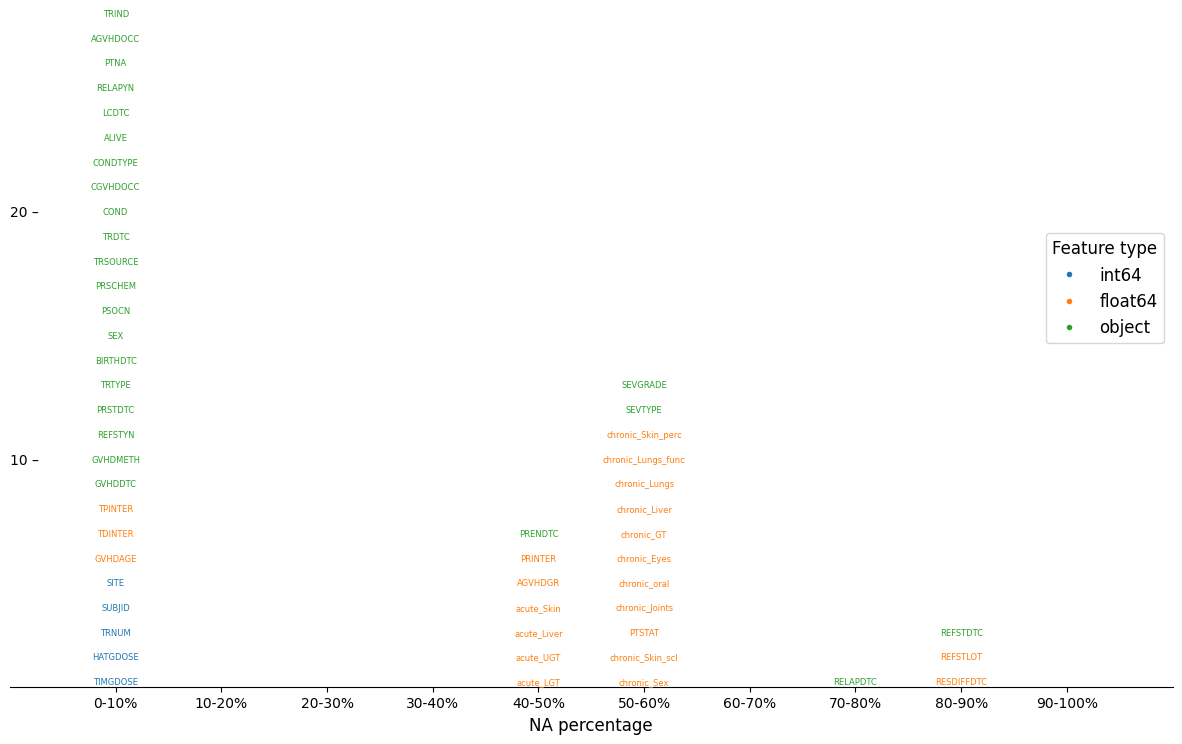

In [9]:
na_text_barplot(disease_data, line_height=1.5)